### This notebook looks to answer the following research questions:
1. Missing values in data
2. How negative flux should be corrected
3. Converting MJD to UNIX time and if it is necessary
4. How to handle class imbalance in training set

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import math

In [157]:
data = 'data/'

In [158]:
train = pd.read_csv(data + 'training_set.csv')

In [159]:
test_chunk = pd.read_csv(data + 'test_set.csv.zip', compression='zip', chunksize=200000)

In [160]:
test = test_chunk.get_chunk()

In [161]:
train_meta = pd.read_csv(data + 'training_set_metadata.csv')

In [162]:
test_meta = pd.read_csv(data + 'test_set_metadata.csv')

In [163]:
train.shape

(1421705, 6)

In [164]:
test.shape

(200000, 6)

In [165]:
train_meta.shape

(7848, 12)

In [166]:
test_meta.shape

(3492890, 11)

In [167]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [168]:
test.head()

,object_id,mjd,passband,flux,flux_err,detected
0,13,59798.3205,2,-1.299735,1.357315,0
1,13,59798.3281,1,-2.095392,1.148654,0
2,13,59798.3357,3,-0.923794,1.763655,0
3,13,59798.3466,4,-4.009815,2.602911,0
4,13,59798.3576,5,-3.403503,5.367328,0


In [169]:
train_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [170]:
test_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023


# 1. Missing values

In [61]:
train.describe()

,object_id,mjd,passband,flux,flux_err,detected,unix_epoch
count,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06
mean,3.392608e+07,6.017921e+04,2.783108e+00,2.468855e+01,2.548932e+01,1.666168e-01,1.692767e+09
std,4.258439e+07,3.092379e+02,1.703946e+00,3.684506e+03,3.814492e+03,3.726336e-01,2.671815e+07
min,6.150000e+02,5.958003e+04,0.000000e+00,-1.149388e+06,4.637530e-01,0.000000e+00,1.640998e+09
25%,1.843400e+05,5.989905e+04,1.000000e+00,-2.789418e+00,2.118670e+00,0.000000e+00,1.668561e+09
50%,4.548783e+06,6.019331e+04,3.000000e+00,7.331990e-01,4.708105e+00,0.000000e+00,1.693985e+09
75%,6.796280e+07,6.048722e+04,4.000000e+00,8.830932e+00,1.297371e+01,0.000000e+00,1.719379e+09
max,1.307798e+08,6.067436e+04,5.000000e+00,2.432809e+06,2.234069e+06,1.000000e+00,1.735548e+09


In [64]:
train.isna().any()

object_id     False
mjd           False
passband      False
flux          False
flux_err      False
detected      False
unix_epoch    False
time          False
dtype: bool

In [65]:
test.isna().any()

object_id     False
mjd           False
passband      False
flux          False
flux_err      False
detected      False
unix_epoch    False
time          False
dtype: bool

In [66]:
train_meta.isna().any()

object_id             False
ra                    False
decl                  False
gal_l                 False
gal_b                 False
ddf                   False
hostgal_specz         False
hostgal_photoz        False
hostgal_photoz_err    False
distmod                True
mwebv                 False
target                False
dtype: bool

Some missing values for distmod, let's see how many:

In [69]:
train_meta['distmod'].isna().value_counts()

False    5523
True     2325
Name: distmod, dtype: int64

In [79]:
print('{:.2f}%'.format((train_meta['distmod'].isna().value_counts()[1]*100)/len(train_meta)))

29.63%


In [81]:
train_meta['distmod'].describe()

count    5523.000000
mean       41.263961
std         2.262711
min        31.996100
25%        39.845250
50%        41.167900
75%        42.398550
max        47.025600
Name: distmod, dtype: float64

Interesting that almost 30% of the distmod values are missing despite hostgal_photoz not having any missing values. Looking rows with missing distmod value:

In [86]:
train_meta[train_meta['distmod'].isna()].head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,NaN,0.020,65
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0,0.0,0.0,NaN,0.018,65
14,2624,346.655182,-63.260487,320.952196,-50.040935,1,0.0,0.0,0.0,NaN,0.019,65
15,2677,53.964844,-28.630989,225.142950,-53.813613,1,0.0,0.0,0.0,NaN,0.009,16


0.0 z measurements from spectromety and photometry in these rows. Does this mean that the redshift is zero or are these missing values? From the caveats in the data section of the competition: "Galactic vs extragalactic: The given redshift for objects in our own galaxy is given as zero."

In [67]:
test_meta.isna().any()

object_id             False
ra                    False
decl                  False
gal_l                 False
gal_b                 False
ddf                   False
hostgal_specz          True
hostgal_photoz        False
hostgal_photoz_err    False
distmod                True
mwebv                 False
dtype: bool

Not many spectrometry measurements of redshift in the test set as previously mentioned.

# 2. How negative flux should be corrected

From the caveats in the data section: "Negative Flux: Due to statistical fluctuations (of e.g. the sky brightness) and the way the brightness is estimated, the flux may be negative for dim sources, where the true flux is close to zero. Second, if the pre-survey image actually contains a flux brighter than its true ‘zero’, this can lead to a negative flux when the difference is computed."

The flux is computed as (flux_image - flux_template) and if flux_template > flux_image, the flux will be negative. In other words, the brightness of the object in the image is lower than the brightness of the object in the reference image for that same part of the sky. Should the lowest negative flux thus be taken as the true 'zero' for each object and every other flux measurement be corrected accordingly? Nonetheless, objects with very low negative flux should be corrected to zero since the true flux is said to be close to zero.

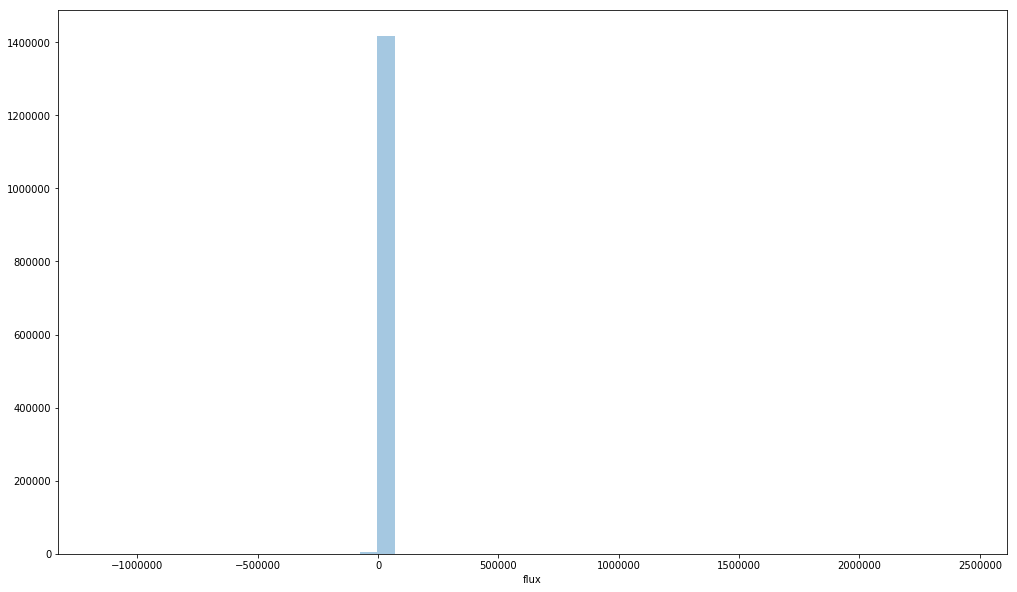

In [113]:
plt.figure(figsize=(17,10))
sns.distplot(train['flux'], kde=False)

In [114]:
train['flux'].describe()

count    1.421705e+06
mean     2.468855e+01
std      3.684506e+03
min     -1.149388e+06
25%     -2.789418e+00
50%      7.331990e-01
75%      8.830932e+00
max      2.432809e+06
Name: flux, dtype: float64

Most flux values are around zero in our training dataset

# 3. Converting MJD to UNIX epoch time and if it is necessary

Modified Julian Time = no. of days since 17/11/1858

UNIX Epoch time = no. of seconds since 00:00:00 UTC 01/01/1970

Creating a new feature in train and test that converts mjd to unix:

In [21]:
train['unix_epoch'] = (train['mjd'] - 40587)*86400

In [27]:
test['unix_epoch'] = (test['mjd'] - 40587)*86400

In [24]:
train.tail()

,object_id,mjd,passband,flux,flux_err,detected,unix_epoch
1421700,130779836,60555.9838,4,-39.881969,46.477093,0,1.725320e+09
1421701,130779836,60560.0459,1,14.894439,18.947685,0,1.725671e+09
1421702,130779836,60571.0225,5,30.593130,50.695290,0,1.726620e+09
1421703,130779836,60585.9974,4,-23.471439,44.819859,0,1.727913e+09
1421704,130779836,60588.0372,0,-41.214264,51.665123,0,1.728090e+09


In [28]:
test.head()

,object_id,mjd,passband,flux,flux_err,detected,unix_epoch
0,13,59798.3205,2,-1.299735,1.357315,0,1.659858e+09
1,13,59798.3281,1,-2.095392,1.148654,0,1.659859e+09
2,13,59798.3357,3,-0.923794,1.763655,0,1.659859e+09
3,13,59798.3466,4,-4.009815,2.602911,0,1.659860e+09
4,13,59798.3576,5,-3.403503,5.367328,0,1.659861e+09


In [23]:
train['unix_epoch'][0]

1655719738.5599997

In [29]:
test['unix_epoch'][0]

1659858091.2

Looking at the year of the first observation in train:

In [30]:
x = train['unix_epoch'][0]

In [37]:
x/60/60/24/365

52.50252849315068

In [36]:
1970 + x/60/60/24/365

2022.5025284931507

Simulated observations are recorded as being taken in 2022. Likely when the LSST will be built and ready to use? Looking at the current time:

In [39]:
time.time()

1541437314.596639

Converting to human readable format:

In [41]:
time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime(time.time()))

'Mon, 05 Nov 2018 17:02:29 +0000'

Converting first observation in train to human readable format:

In [42]:
time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime(x))

'Mon, 20 Jun 2022 11:08:58 +0000'

Adding this as a feature:

In [57]:
train['time'] = [time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime(x)) for x in train['unix_epoch']]

In [59]:
test['time'] = [time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime(x)) for x in test['unix_epoch']]

In [58]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected,unix_epoch,time
0,615,59750.4229,2,-544.810303,3.622952,1,1.655720e+09,"Mon, 20 Jun 2022 11:08:58 +0000"
1,615,59750.4306,1,-816.434326,5.553370,1,1.655720e+09,"Mon, 20 Jun 2022 11:20:03 +0000"
2,615,59750.4383,3,-471.385529,3.801213,1,1.655721e+09,"Mon, 20 Jun 2022 11:31:09 +0000"
3,615,59750.4450,4,-388.984985,11.395031,1,1.655722e+09,"Mon, 20 Jun 2022 11:40:48 +0000"
4,615,59752.4070,2,-681.858887,4.041204,1,1.655891e+09,"Wed, 22 Jun 2022 10:46:04 +0000"


In [80]:
test.head()

,object_id,mjd,passband,flux,flux_err,detected,unix_epoch,time
0,13,59798.3205,2,-1.299735,1.357315,0,1.659858e+09,"Sun, 07 Aug 2022 08:41:31 +0000"
1,13,59798.3281,1,-2.095392,1.148654,0,1.659859e+09,"Sun, 07 Aug 2022 08:52:27 +0000"
2,13,59798.3357,3,-0.923794,1.763655,0,1.659859e+09,"Sun, 07 Aug 2022 09:03:24 +0000"
3,13,59798.3466,4,-4.009815,2.602911,0,1.659860e+09,"Sun, 07 Aug 2022 09:19:06 +0000"
4,13,59798.3576,5,-3.403503,5.367328,0,1.659861e+09,"Sun, 07 Aug 2022 09:34:56 +0000"


This doesn't seem to be useful for building a model but fun to look at nonetheless.

In [138]:
train=train.drop(['unix_epoch', 'time'], axis=1)
test=test.drop(['unix_epoch', 'time'], axis=1)

# 4. How to handle class imbalance in training set

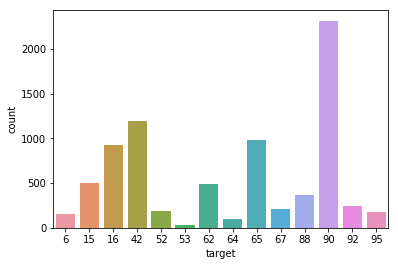

In [19]:
sns.countplot(train_meta['target'])

In [89]:
train_meta['target'].value_counts()

90    2313
42    1193
65     981
16     924
15     495
62     484
88     370
92     239
67     208
52     183
95     175
6      151
64     102
53      30
Name: target, dtype: int64